Simple EDA process

install GDCM package

In [1]:
!conda install -c conda-forge gdcm -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.7 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h5d359c0_2
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.1.0-h7f98852_0

The following packages 

Importing necessary packages

In [2]:
import numpy as np
import pandas as pd
import os
import pydicom
import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')

Listing all the files available

In [3]:
dataset_path = Path('../input/siim-covid19-detection')
l1=dataset_path.ls()
for l in l1:
    print(l)

../input/siim-covid19-detection/sample_submission.csv
../input/siim-covid19-detection/train_image_level.csv
../input/siim-covid19-detection/test
../input/siim-covid19-detection/train
../input/siim-covid19-detection/train_study_level.csv


Viewing Study Level CSV

In [4]:
train_study_df = pd.read_csv(dataset_path/'train_study_level.csv')
print(train_study_df.shape)
train_study_df.head()

(6054, 5)


,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


Storing unique studyIDs

In [5]:
lst = np.unique(train_study_df.id)
len(lst)

6054

Print unique classes in Study Level
Note: Target classes are One Hot Encoded

In [6]:
study_classes = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
np.unique(train_study_df[study_classes].values, axis=0)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

Plotting the Class vs Frequency graph - Study Level

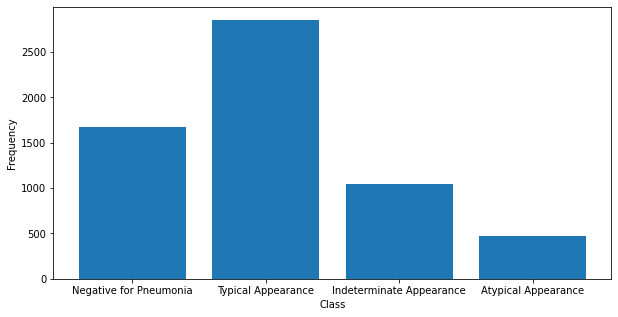

In [7]:
plt.figure(figsize=(10,5))
plt.bar([1,2,3,4], train_study_df[study_classes].values.sum(axis=0))
plt.xticks([1,2,3,4], study_classes)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Viewing Image Level CSV

In [8]:
train_image_df = pd.read_csv(dataset_path/'train_image_level.csv')
print(train_image_df.shape)
train_image_df.head()

(6334, 4)


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


Splitting the label attribute of image level CSV

In [9]:
train_image_df['split_label'] = train_image_df.label.apply(lambda x:[x.split()[offs:offs+6] for offs in range(0, len(x.split()),6)])
train_image_df.head()

,id,boxes,label,StudyInstanceUID,split_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]"
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]"
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]"
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]"
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]"


Finding Class Frequency and Area under box frequency

Text(0, 0.5, 'Frequency')

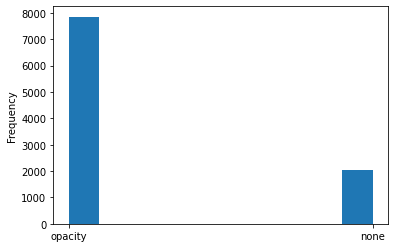

In [10]:
classes_freq = []
bbox_areas = []
for i in range(len(train_image_df)):
    for j in train_image_df.iloc[i].split_label:
        classes_freq.append(j[0])
        bbox_areas.append((float(j[4])-float(j[2]))*(float(j[5])*float(j[3])))
plt.hist(classes_freq)
plt.ylabel('Frequency')

Plotting Bounding Box Areas

Text(0, 0.5, 'Frequency')

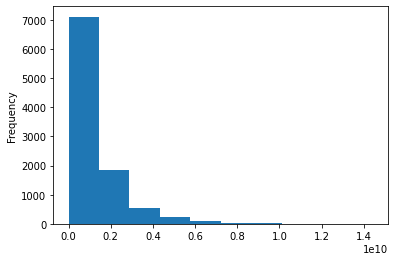

In [11]:
plt.hist(bbox_areas)
plt.ylabel('Frequency')

Functions to convert .dcm to numpy arrays

In [12]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data*255).astype(np.uint8)
    return data

def plot_img(img, size=(7,7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500, 500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

Plotting x-ray images

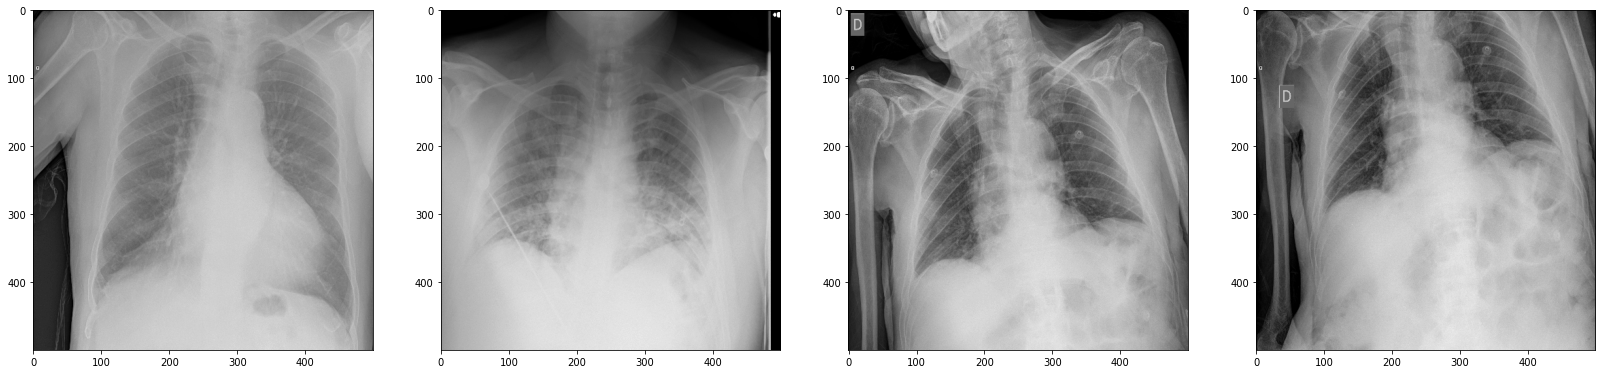

In [13]:
dicom_paths = get_dicom_files(dataset_path/'train')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

Study with more than 3 images

Study ../input/siim-covid19-detection/train/79c3bf957d49 has 4 images
Study ../input/siim-covid19-detection/train/7e91e041c7d4 has 4 images
Study ../input/siim-covid19-detection/train/8943d1d85097 has 6 images
Study ../input/siim-covid19-detection/train/0fd2db233deb has 9 images
Study ../input/siim-covid19-detection/train/a7335b2f9815 has 7 images
Study ../input/siim-covid19-detection/train/c39d68397d84 has 4 images
Study ../input/siim-covid19-detection/train/a0254bf8a96e has 5 images
Study ../input/siim-covid19-detection/train/970c96c9fa5d has 5 images
Study ../input/siim-covid19-detection/train/a4e94133d95a has 5 images
Study ../input/siim-covid19-detection/train/74ba8f2badcb has 4 images


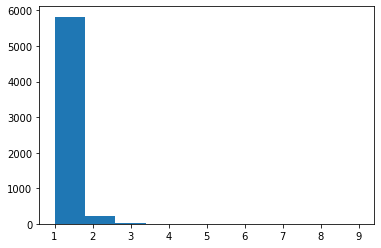

In [14]:
num_images_per_study = []
for i in (dataset_path/'train').ls():
    num_images_per_study.append(len(get_dicom_files(i)))
    if len(get_dicom_files(i))>3:
        print(f'Study {i} has {len(get_dicom_files(i))} images')
plt.hist(num_images_per_study)
plt.show()

Extracting image paths

In [15]:
def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem:
            return i
train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)
train_image_df.head()

,id,boxes,label,StudyInstanceUID,split_label,image_path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]",../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]",../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]",../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]",../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]",../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm


Plotting bounding box in x-ray images

../input/siim-covid19-detection/train/3dedb0639734/0fe5087f9c8d/749193cb46cd.dcm
../input/siim-covid19-detection/train/bebaafc7bfbe/83c109cdb4b6/e16d2a45229d.dcm
../input/siim-covid19-detection/train/308464f7fda3/0dac1741fa48/b7f8f012a3c4.dcm
../input/siim-covid19-detection/train/f11ab7648eb2/25357854989e/3959ceb9bbce.dcm
../input/siim-covid19-detection/train/6ac2e9a9f5a8/7e5fcb7d59ba/b37424c5f376.dcm
../input/siim-covid19-detection/train/96448f229e67/5208dbffae2f/4785ca6ddafa.dcm
../input/siim-covid19-detection/train/2e58096bdbd9/bd542423c72b/a9fe960e8d9f.dcm
../input/siim-covid19-detection/train/4bdad39035b0/1647124698fd/1a0e966f2d57.dcm


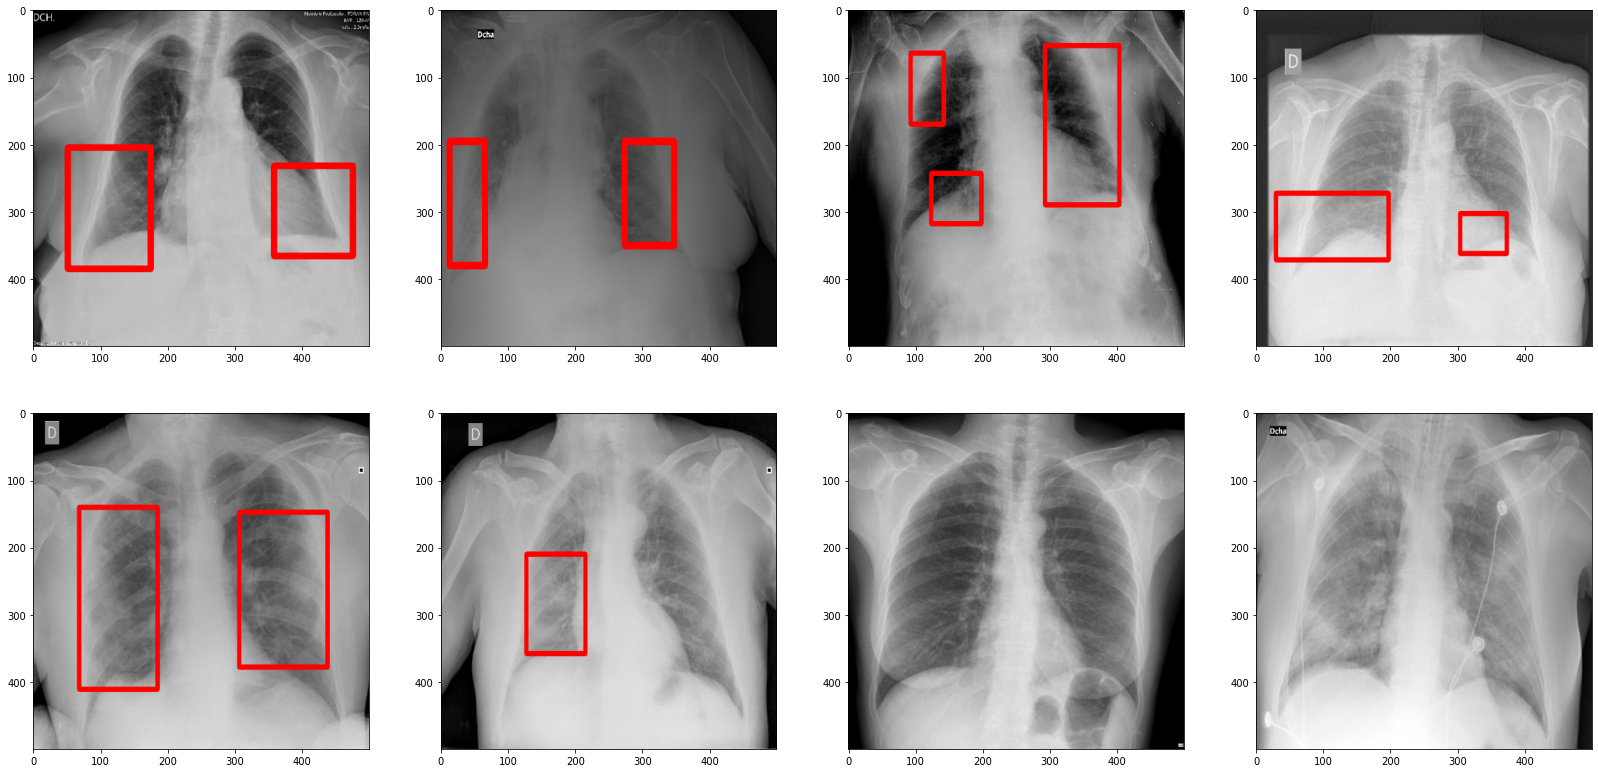

In [16]:
imgs = []
image_paths = train_image_df['image_path'].values
# map label_id to specify color
thickness = 10
scale = 5
for i in range(8):
    image_path = random.choice(image_paths)
    print(image_path)
    img = dicom2array(path=image_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    for i in train_image_df.loc[train_image_df['image_path'] == image_path].split_label.values[0]:
        if i[0] == 'opacity':
            img = cv2.rectangle(img,
                                (int(float(i[2])/scale), int(float(i[3])/scale)),
                                (int(float(i[4])/scale), int(float(i[5])/scale)),
                                [255,0,0], thickness)
    img = cv2.resize(img, (500,500))
    imgs.append(img)
plot_imgs(imgs, cmap=None)